# Preparations

In this notebook we will present examples on how to use library BBMetric for evaluate our chatbots.

In [1]:
# Various imports to load the metric library, the model, the tokenizer, and the characters data
from lib.BBMetrics import BBMetric
from transformers import TFAutoModelForCausalLM, AutoTokenizer
import os
from lib.BBData import character_dict, source_dict, random_state, model_name
from transformers import AdamWeightDecay
import os

# Mount google drive, if in Colaboratory environment
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    base_folder = '/content/drive/My Drive/unibo/NLP_project/BarneyBot'
    os.system("pip install datasets")
    os.system("pip install transformers")
    os.system("pip install rouge_score")
    os.system("pip install -U sentence-transformers")
else:
    base_folder = '..'

out_folder = os.path.join(base_folder, 'Data', 'Characters')
# Get Barney character folder, as an example
barney_folder = os.path.join(out_folder, 'Barney')
if not os.path.exists(barney_folder):
    os.makedirs(barney_folder)
    
# Create some basic sentences to feed to the metrics
sentences_basic = ["Hi!", "How are you?", "I hate you."]
sentences_basic_2 = ["Hello!", "How are you doing?", "I think this is good."]
sentences_vader = ["Come to the dark side!", "I will kill you!", "Luke, I am your father."]
sentences_barney = ["Did you get the suit?", "Legendary!", "I like girls."]

Below a model from the checkpoint `microsoft/DialoGPT-small` is loaded with its corresponding tokenizer and setting the padding token to `#`

In [2]:
# Load and compile dialogpt defaul model
model = TFAutoModelForCausalLM.from_pretrained(model_name, cache_dir=os.path.join(base_folder, "cache"))
model.compile(optimizer=AdamWeightDecay(learning_rate=2e-5))
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=os.path.join(base_folder, "cache"))
tokenizer.pad_token = '#'

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at microsoft/DialoGPT-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In the following cell the Barney model is loaded and a conversation is preprocessed. Then the HuggingFace dataset is transformod into a tensorflow one, ready to be fed to the model

In [3]:
# Functions to load a dataset and prepare it, used for perplexity
from datasets import load_dataset, DatasetDict
from transformers import DataCollatorForLanguageModeling
from lib.BBDataLoad import load_char_df, dialogpt_preprocess_function

# Select a batch size, used for perplexity
batch_size = 8

# Load the Barney dialogpt finetuned model
model_barney = TFAutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=\
                                            os.path.join(barney_folder, character_dict['Barney']['checkpoint_folder']))
model_barney.compile(optimizer=AdamWeightDecay(learning_rate=2e-5))
data_collator = DataCollatorForLanguageModeling(mlm=False, tokenizer=tokenizer, return_tensors='tf')

# Load the Barney dataset and process it as a conversation
barney_hg = load_char_df('Barney', base_folder)
tokenized_barney_hg = barney_hg.map(lambda row: dialogpt_preprocess_function(row, tokenizer), batched=False)
# Transform the HuggingFace dataset as a tensorflow one, ready to be fed to the model
barney_test_set = tokenized_barney_hg["test"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ..\Data\Characters\Barney\barney_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.
Using custom data configuration default-b7f40de658ae065e


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to cache\csv\default-b7f40de658ae065e\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4414 [00:00<?, ?ex/s]

  0%|          | 0/522 [00:00<?, ?ex/s]

  0%|          | 0/258 [00:00<?, ?ex/s]

# Running Metrics

`BBMetric.metrics_list` show up the list of all the available metrics

In [4]:
# Display the available metrics list
BBMetric.metrics_list

['bleu',
 'semantic similarity',
 'rouge l',
 'emotion',
 'semantic answer similarity',
 'distinct',
 'neural chatbot classifier',
 'perplexity',
 'human - coherence',
 'human - consistency',
 'human - style']

`BBMetric.load_metric(metric_name)` load the specified metric with name `metric_name` by loading the respective model or algorithm which computes it. It will return the `metric` asked ready to be compute by invoking `metric.compute`. Some metrics (such as the human ones and the semantic classifier) require training, in which case a method `metric.train` is provided.

In [ ]:
# BLEU on a pair of sets of sentences
metric = BBMetric.load_metric("bleu")

print(metric.compute(predictions=sentences_basic, references=sentences_basic_2))

In [ ]:
# Rouge-L on a pair of sets of sentences
metric = BBMetric.load_metric("rouge l")

print(metric.compute(predictions=sentences_basic, references=sentences_basic_2))

In [ ]:
# Distinct on a set of sentences
metric = BBMetric.load_metric("distinct")

# ngram_size is optional, defaults to 3
metric.compute(sentences=sentences_basic, ngram_size=2)

In [ ]:
# Emotion labeling on a set of sentences
metric = BBMetric.load_metric("emotion")

print(metric.compute(sentences=sentences_basic))

In [ ]:
# Semantic Similarity (similar to BERTScore) on a pair of sets of sentences
metric = BBMetric.load_metric("semantic similarity")

print(metric.compute(sentences_a=sentences_basic, sentences_b=sentences_basic_2))

In [ ]:
# Semantic Answer Similarity on a pair of sets of sentences
metric = BBMetric.load_metric("semantic answer similarity")

print(metric.compute(predictions=sentences_basic, references=sentences_basic_2))

Creating encoded lines



  5%|███▋                                                                           | 129/2750 [00:10<04:03, 10.78it/s]


  9%|███████▍                                                                       | 261/2750 [00:21<03:25, 12.12it/s]


 14%|███████████▏                                                                   | 391/2750 [00:32<02:31, 15.60it/s]


 19%|███████████████                                                                | 523/2750 [00:40<02:29, 14.94it/s]


 24%|██████████████████▊                                                            | 655/2750 [00:49<02:08, 16.26it/s]


 29%|██████████████████████▌                                                        | 787/2750 [00:57<01:59, 16.45it/s]


 33%|██████████████████████████▍                                                    | 919/2750 [01:06<02:02, 14.89it/s]


 38%|█████████████████████████████▊                                                | 1051/2750 [01:15<01:51, 15.25it/s]


 43%|█████████████████████████████████▌                                            | 1183/2750 [01:24<01:48, 14.50it/s]


 48%|█████████████████████████████████████▎                                        | 1315/2750 [01:32<01:39, 14.40it/s]


 53%|█████████████████████████████████████████                                     | 1447/2750 [01:41<01:21, 16.02it/s]


 57%|████████████████████████████████████████████▊                                 | 1579/2750 [01:49<01:15, 15.53it/s]


 62%|████████████████████████████████████████████████▌                             | 1711/2750 [01:57<01:04, 15.99it/s]


 67%|████████████████████████████████████████████████████▎                         | 1843/2750 [02:06<00:55, 16.30it/s]


 72%|████████████████████████████████████████████████████████                      | 1975/2750 [02:14<00:57, 13.43it/s]


 77%|███████████████████████████████████████████████████████████▊                  | 2107/2750 [02:23<00:39, 16.29it/s]


 81%|███████████████████████████████████████████████████████████████▌              | 2239/2750 [02:31<00:31, 16.01it/s]


 86%|███████████████████████████████████████████████████████████████████▎          | 2371/2750 [02:39<00:23, 16.26it/s]


 91%|██████████████████████████████████████████████████████████████████████▉       | 2503/2750 [02:47<00:15, 16.19it/s]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2635/2750 [02:57<00:10, 11.13it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 2750/2750 [03:04<00:00, 14.88it/s]


Saved encoded lines at ..\data\Characters\Vader
Loaded encoded lines from ..\data\Characters\Vader
Running shuffle 0/10



100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 9856.47it/s]


Running shuffle 1/10



100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 9877.92it/s]


Running shuffle 2/10



100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 9874.24it/s]


Running shuffle 3/10



100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7889.19it/s]


Running shuffle 4/10



100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 9875.13it/s]


Running shuffle 5/10



100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7894.36it/s]


Running shuffle 6/10



100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7889.76it/s]


Running shuffle 7/10



100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7892.01it/s]


Running shuffle 8/10



100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 9857.94it/s]


Running shuffle 9/10



100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7899.73it/s]


Loading training data...



100%|████████████████████████████████████████████████████████████████████████████| 2686/2686 [00:01<00:00, 2572.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 2686/2686 [00:00<?, ?it/s]


Loading test data...



100%|██████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 2489.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<?, ?it/s]


Loading validation data...



100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 2632.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<?, ?it/s]


Epoch 1/1000
168/168 [==============================] - 7s 34ms/step - loss: 0.9065 - binary_accuracy: 0.5279 - recall_1: 0.5332 - val_loss: 0.7692 - val_binary_accuracy: 0.4937 - val_recall_1: 1.0000
Epoch 2/1000
168/168 [==============================] - 5s 32ms/step - loss: 0.8464 - binary_accuracy: 0.5495 - recall_1: 0.5496 - val_loss: 0.7386 - val_binary_accuracy: 0.5380 - val_recall_1: 0.8333
Epoch 3/1000
168/168 [==============================] - 5s 32ms/step - loss: 0.8230 - binary_accuracy: 0.5707 - recall_1: 0.5772 - val_loss: 0.7294 - val_binary_accuracy: 0.5949 - val_recall_1: 0.7308
Epoch 4/1000
168/168 [==============================] - 5s 32ms/step - loss: 0.7743 - binary_accuracy: 0.5975 - recall_1: 0.5988 - val_loss: 0.7451 - val_binary_accuracy: 0.5886 - val_recall_1: 0.5769
Epoch 5/1000
168/168 [==============================] - 6s 35ms/step - loss: 0.7307 - binary_accuracy: 0.6214 - recall_1: 0.6294 - val_loss: 0.7463 - val_binary_accuracy: 0.6076 - val_recall_1: 0.

168/168 [==============================] - 5s 32ms/step - loss: 0.2423 - binary_accuracy: 0.9181 - recall_1: 0.9210 - val_loss: 0.1774 - val_binary_accuracy: 0.9557 - val_recall_1: 0.9487
Epoch 42/1000
168/168 [==============================] - 5s 32ms/step - loss: 0.2577 - binary_accuracy: 0.9054 - recall_1: 0.9098 - val_loss: 0.1711 - val_binary_accuracy: 0.9557 - val_recall_1: 0.9487
Epoch 43/1000
168/168 [==============================] - 5s 32ms/step - loss: 0.2353 - binary_accuracy: 0.9203 - recall_1: 0.9277 - val_loss: 0.1636 - val_binary_accuracy: 0.9620 - val_recall_1: 0.9487
Epoch 44/1000
168/168 [==============================] - 5s 32ms/step - loss: 0.2250 - binary_accuracy: 0.9244 - recall_1: 0.9299 - val_loss: 0.1588 - val_binary_accuracy: 0.9747 - val_recall_1: 0.9615
Epoch 45/1000
168/168 [==============================] - 5s 32ms/step - loss: 0.2263 - binary_accuracy: 0.9203 - recall_1: 0.9239 - val_loss: 0.1535 - val_binary_accuracy: 0.9747 - val_recall_1: 0.9615
Epoc

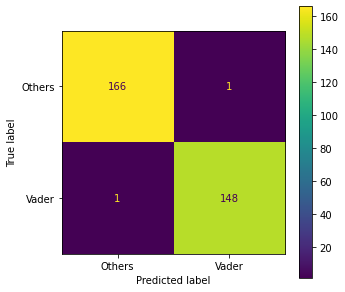

INFO:tensorflow:Assets written to: ..\data\Characters\Vader\vader_classifier\assets
{'score': 0.040977347642183304, 'std': 0.040348611772060394}
{'score': 0.6410245895385742, 'std': 0.23668399453163147}
{'score': 0.10722760111093521, 'std': 0.08116284012794495}


In [8]:
# Semantic Classifier on a set of sentences
metric = BBMetric.load_metric("neural chatbot classifier")

# n_shuffles is optional, defaults to 10
# from_saved_embeddings is optional, defaults to True
# shutdown_at_end is optional, defaults to False
'''
metric.train(character='Barney', random_state=random_state,
             source_encoded_path=os.path.join(base_folder, "Data", "Characters", 'Barney'),
             source_path=None, source_save_path=None, save_path=os.path.join(base_folder, "data", "Characters", 'Barney', character_dict["Barney"]['classifier_folder']),
             n_shuffles=10, shutdown_at_end=False)
'''
metric.train(character='Vader', random_state=random_state,
             source_encoded_path=None,
             source_path=os.path.join(base_folder, "data", "Sources", character_dict["Vader"]['source'], character_dict["Vader"]['source'] + ".csv"),
             source_save_path=os.path.join(base_folder, "data", "Characters", 'Vader'),
             save_path=os.path.join(base_folder, "data", "Characters", 'Vader'),
             n_shuffles=10, shutdown_at_end=False)

# Computations for Barney semantic classifier on different sets of sentences
print(metric.compute(character='Vader',
                     load_path=os.path.join(base_folder, "Data", "Characters", 'Vader', character_dict["Vader"]['classifier_folder']),
                     sentences=sentences_basic))
print(metric.compute(character='Vader',
                     load_path=os.path.join(base_folder, "Data", "Characters", 'Vader', character_dict["Vader"]['classifier_folder']),
                     sentences=sentences_vader))
print(metric.compute(character='Vader',
                     load_path=os.path.join(base_folder, "Data", "Characters", 'Vader', character_dict["Vader"]['classifier_folder']),
                     sentences=sentences_barney))

In [ ]:
# Perplexity on an encoded test set (taken from one of our datasets)
metric = BBMetric.load_metric("perplexity")

print(metric.compute(model=model_barney, encoded_test_set=barney_test_set))

In [ ]:
# Human - coherence metric
metric = BBMetric.load_metric("human - coherence")

# Ask a human to perform evaluation
# length is optional, defaults to 5
metric.train(model=model, tokenizer=tokenizer,
             filepath=os.path.join(os.getcwd(), "Data", "Characters", "Default", "humancoherence.csv"),
             length=5)

# Print score averages
metric.compute(filepath=os.path.join(os.getcwd(), "Data", "Characters", "Default", "humancoherence.csv"))

In [ ]:
# Human - consistency metric
metric = BBMetric.load_metric("human - consistency")

# Ask a human to perform evaluation
metric.train(model=model, tokenizer=tokenizer,
             filepath=os.path.join(os.getcwd(), "Data", "Characters", "Default", "humanconsistency.csv"))

# Print score averages
metric.compute(filepath=os.path.join(os.getcwd(), "Data", "Characters", "Default", "humanconsistency.csv"))

In [ ]:
# Human - style metric
metric = BBMetric.load_metric("human - style")

# Ask a human to perform evaluation
metric.train(model=model, tokenizer=tokenizer,
             filepath=os.path.join('..', "Data", "Characters", "Default", "humanstyle.csv"),
             questions=barney_sentences)

# Print score averages
metric.compute(filepath=os.path.join('..', "Data", "Characters", "Default", "humanstyle.csv"))